## Springboard Data Science Track Capstone Project 2
### Music Genre Classification from Audio Samples
### by Morgan Fry
### Data Exploration and Inferential Statistics notebook


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
%matplotlib inline
import librosa
import librosa.display
import IPython.display as ipd

import pickle
import seaborn as sns
from scipy.stats import pearsonr


#### Let's start with the relevant features from one audio clip

In [2]:
audio_paths=pickle.load(open("saved/audio_paths.p","rb"))

In [3]:
ipd.Audio(audio_paths[18045],rate=22050)

In [4]:
#look at a 3-second clip
x, sr = librosa.load(audio_paths[18045],duration=10)


/home/morganfry/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


The most common visualization of sound is a plot of the amplitude envelope of the soundwave. This is equivalent to plotting the 1-d array containing the sample as a time series.  
The shape of the array is sample rate * sample length in seconds.

In [5]:
print(type(x))
print(x.shape)

<class 'numpy.ndarray'>
(220500,)


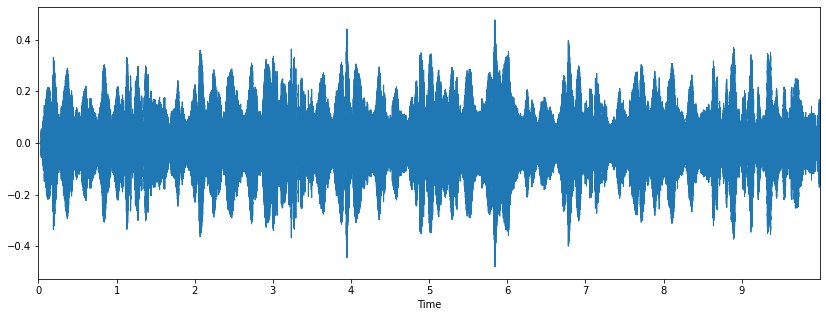

In [6]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
plt.show()

It is more useful for our purposes to look at the frequency spectrum. Not just how loud the entire sample is at any time but what frequencies are present.

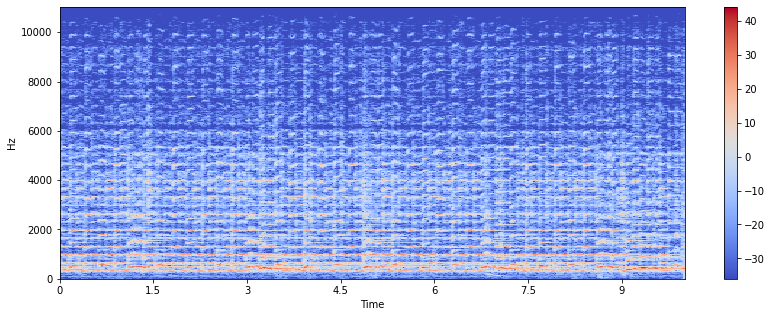

In [7]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.show()

Musical instruments have most of their sound in the 50-2000 Hz range, and as we can see there is a lot more information in the lower frequencies, so looking at the log of the frequencies will be more instructive.

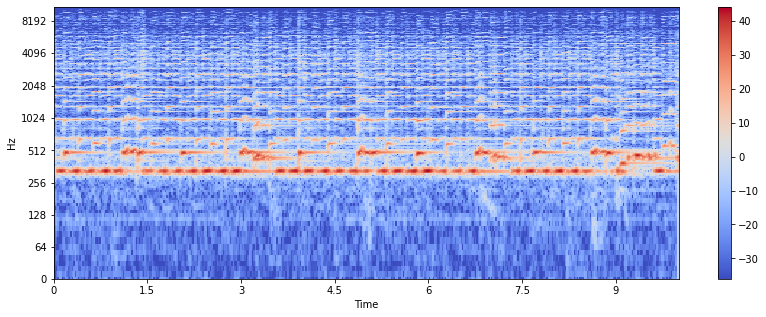

In [8]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

In this case it is a solo violin, so the open strings are from about 200Hz to about 700Hz, and we can see that most of the sound is in the 300Hz to 2000Hz range.

Even more useful is the use of Mel-frequency cepestral coefficients (MFCC). An MFCC is a representation of the power spectrum of a sound, it uses the following transformations of the signal:
* Fourier transformation of the signal
* Mapping that onto the mel scale
* Take the log of the powers at each mel frequency
* Discrete cosine transform of those log powers
  
The mel scale noted above is a scale of pitches that we perceive to be equidistant from each other. For instance every multiple of 440Hz is the note 'A', the difference between 220 and 440 is perveiced as the same as the difference between 440 and 880.

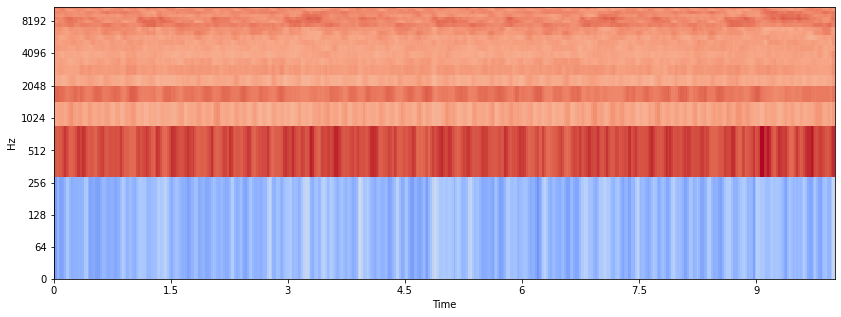

In [9]:
#MFCCs
mfccs = librosa.feature.mfcc(x, sr=sr)

plt.figure(figsize=(14,5))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', y_axis='log')
plt.show()

Given that MFCCs are a simple transformation and bear a strong relationship to how we percieve music, we will use this feature as the basis for our classification.

Let's have a look at the distribution of the classes.

In [10]:
genres=pd.read_csv('data/genres.csv', index_col=0)
genres.head()

,#tracks,parent,title,top_level
genre_id,,,,
1,8693,38,Avant-Garde,38
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5


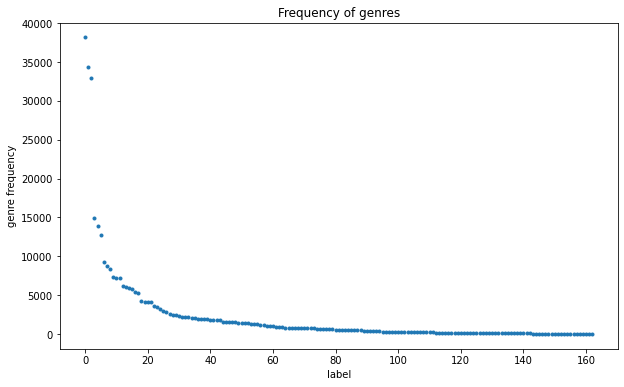

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(genres)),genres['#tracks'].sort_values(ascending=False),marker='.')
plt.title('Frequency of genres')
plt.xlabel('label')
plt.ylabel('genre frequency')
plt.show()

In [12]:
features=pd.read_csv('data/features.csv',index_col=0, header=[0,1,2])

In [13]:
tracks=pd.read_csv('data/tracks.csv',header=[0,1],index_col=0,dtype=str)

In [14]:
for each in features.columns:
    print(each)

('chroma_cens', 'kurtosis', '01')
('chroma_cens', 'kurtosis', '02')
('chroma_cens', 'kurtosis', '03')
('chroma_cens', 'kurtosis', '04')
('chroma_cens', 'kurtosis', '05')
('chroma_cens', 'kurtosis', '06')
('chroma_cens', 'kurtosis', '07')
('chroma_cens', 'kurtosis', '08')
('chroma_cens', 'kurtosis', '09')
('chroma_cens', 'kurtosis', '10')
('chroma_cens', 'kurtosis', '11')
('chroma_cens', 'kurtosis', '12')
('chroma_cens', 'max', '01')
('chroma_cens', 'max', '02')
('chroma_cens', 'max', '03')
('chroma_cens', 'max', '04')
('chroma_cens', 'max', '05')
('chroma_cens', 'max', '06')
('chroma_cens', 'max', '07')
('chroma_cens', 'max', '08')
('chroma_cens', 'max', '09')
('chroma_cens', 'max', '10')
('chroma_cens', 'max', '11')
('chroma_cens', 'max', '12')
('chroma_cens', 'mean', '01')
('chroma_cens', 'mean', '02')
('chroma_cens', 'mean', '03')
('chroma_cens', 'mean', '04')
('chroma_cens', 'mean', '05')
('chroma_cens', 'mean', '06')
('chroma_cens', 'mean', '07')
('chroma_cens', 'mean', '08')
('ch

#### Let's look at the pairwise correlation between features. Because we are going to trin the model on the MFCCs, we'll look at the correlations between the various MFCC values.

A chroma vector is a typically a 12-element feature vector indicating how much energy of each pitch class, {C, C#, D, D#, E, ..., B}, is present in the signal. Chroma energy normalized statistics (CENS) take statistics over large windows, smoothing local deviations in tempo, articulation, and musical ornaments such as trills and arpeggiated chords. This makes CENS useful for tasks such as audio matching and similarity.


In [15]:
chroma_cens=features['chroma_cens']

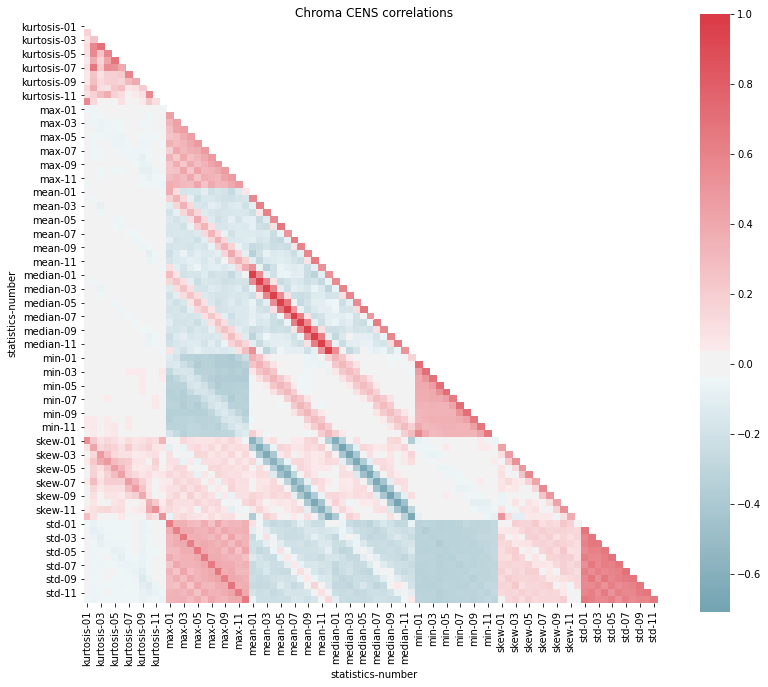

In [16]:
cens_corr = chroma_cens.corr()
mask= np.triu(np.ones_like(cens_corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(13, 11))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cens_corr, mask=mask, cmap=cmap, center=0,
            square=True).set_title('Chroma CENS correlations')
plt.show()

Let's isolate the very high correlations:

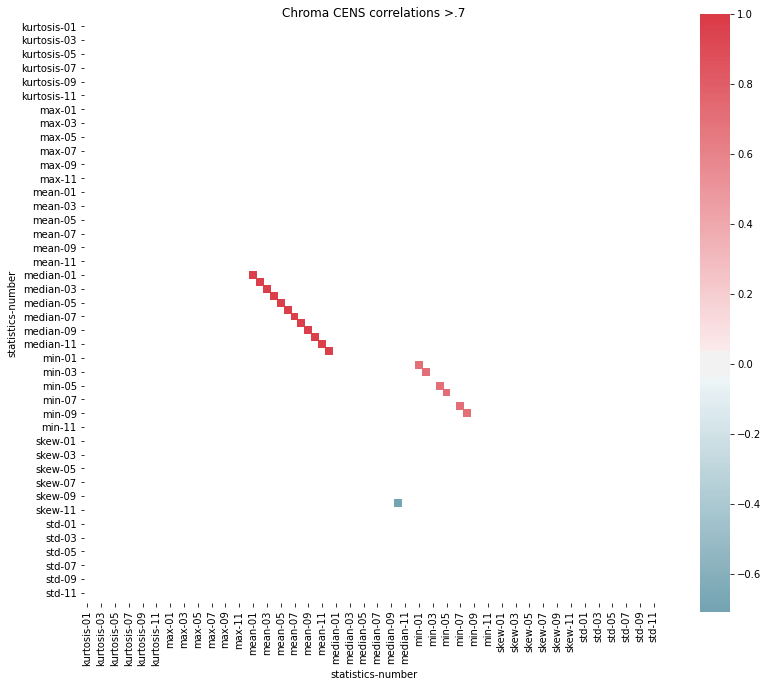

In [17]:
f, ax = plt.subplots(figsize=(13, 11))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cens_corr[np.abs(cens_corr) >= .7],
            mask=mask,
            cmap=cmap,
            center=0,
            square=True).set_title('Chroma CENS correlations >.7')
plt.show()

There are just a few highly correlated pairs inthese features, namely the mean and median are highly correlated. The minima are also close to their neighbors. One standout pair is median-11 and skew-11:

In [18]:
cens_p=pearsonr(cens_corr['median','11'], cens_corr['skew','11'])
print(f'r-value: {cens_p[0]:2f}')
print(f'p-value: {cens_p[1]:.2f}')

r-value: -0.868077
p-value: 0.00


In [19]:
corrs=np.sort(cens_corr.values.flatten())
n_corrs=len(corrs)
p025=int(n_corrs*.025)-cens_corr.shape[0] #offset by the self-intersections
p975=int(n_corrs*.975)-cens_corr.shape[0]

p95=[corrs[p025],corrs[p975]]

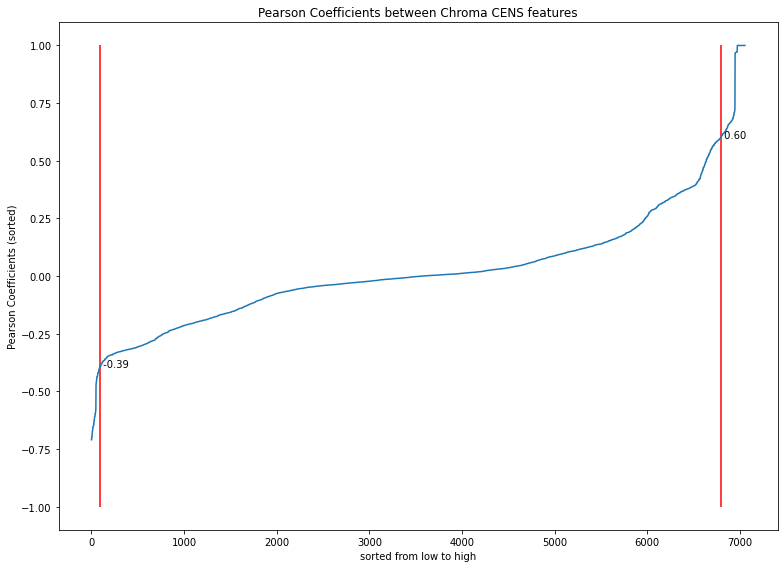

In [20]:
plt.figure(figsize=(11, 8))
plt.plot(corrs)
plt.vlines(x=p025, ymin=-1, ymax=1, label='2.5%', color='red')
plt.vlines(x=p975, ymin=-1, ymax=1, label='97.5%', color='red')
#plt.scatter(x=p025, y=p95[0], marker='o',color='black')
#plt.scatter(x=p975, y=p95[1], marker='o',color='black')
plt.annotate(' {:.2f}'.format(p95[0]),(p025,p95[0]))
plt.annotate(' {:.2f}'.format(p95[1]),(p975,p95[1]))
plt.title('Pearson Coefficients between Chroma CENS features')
plt.xlabel('sorted from low to high')
plt.ylabel('Pearson Coefficients (sorted)')
plt.tight_layout()
plt.show()

For the Chroma CENS features, 95% of the pairwise correlation values are between -.39 and .60. As noted earlier, most of the highly correlated pairs are in neighboring features, a consequence of a small sample of sound tending to sound like its neighbors.

In [21]:
mfccs=features['mfcc']

In [22]:
corr=mfccs.corr()
mask= np.triu(np.ones_like(corr, dtype=np.bool))

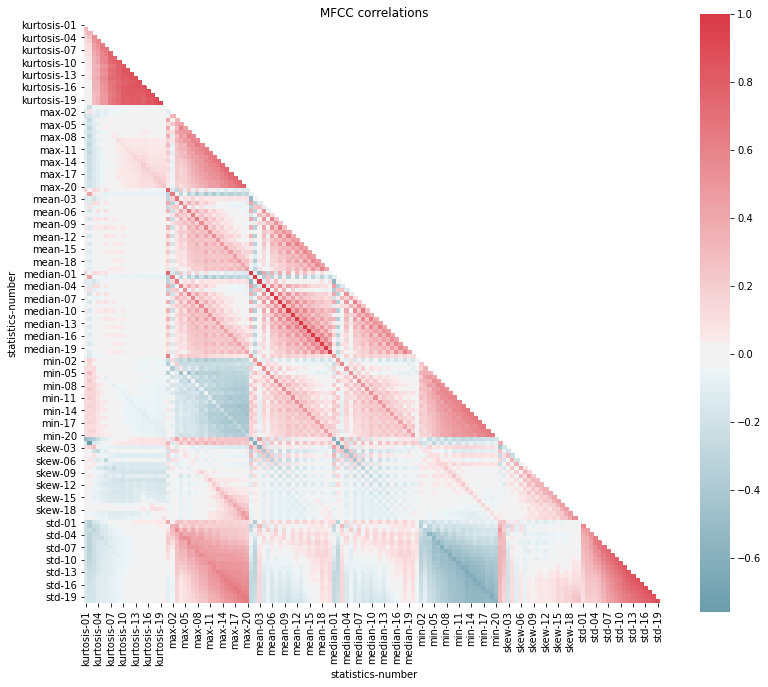

In [23]:
f, ax = plt.subplots(figsize=(13, 11))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True).set_title('MFCC correlations')
plt.show()

So there is some correlation between a few sets of features. Let's single out the higher correlation pairs.

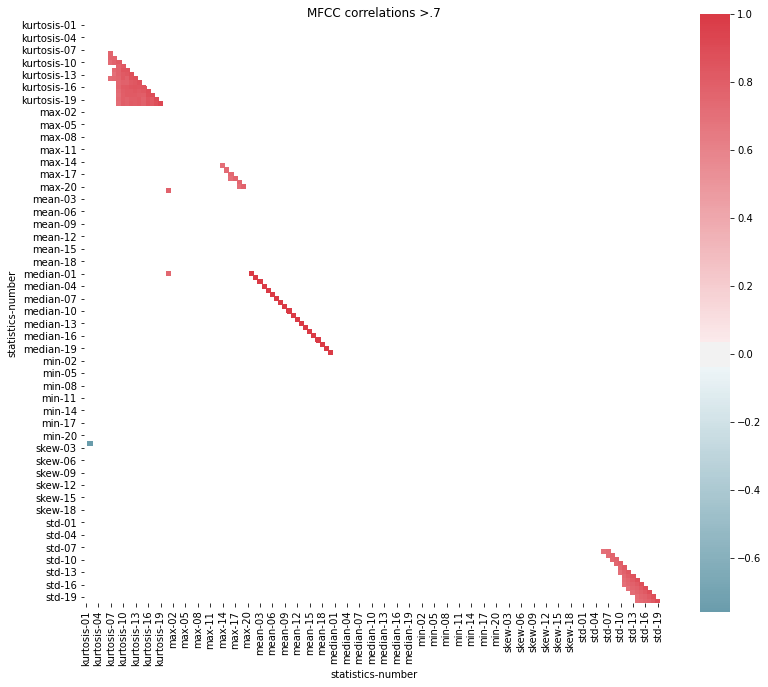

In [24]:
f, ax = plt.subplots(figsize=(13, 11))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr[np.abs(corr) >= .7],
            mask=mask,
            cmap=cmap,
            center=0,
            square=True).set_title('MFCC correlations >.7')
plt.show()

We are looking at statistical features of the mfccs, such as max, min, median, skew, kurtosis, etc. From the documentation of the librosa fucntions that constructed the mfccs, we can see that they are ~23ms long, with 50% overlapping the previous and next samples. We can notice a few things from the matrix of pairwise correlations above:  
* The columns that have strong correlation are generally close to eachother. e.g. median 10 and median 13 have correlation of .706
* Most of the correlations can be attributed to nearness in time to eachother and the fact that they share some underlying data due to the sampling overlap
* Skew 03 and Kurtosis 01 are the only outliers to this pattern with a -.867 pearson coefficient:

In [25]:

p_kurt = pearsonr(corr['kurtosis', '01'], corr['skew', '01'])

print(f'r-value: {p_kurt[0]:2f}')
print(f'p-value: {p_kurt[1]:.2f}')

r-value: -0.867891
p-value: 0.00


In [26]:
corrs=np.sort(corr.values.flatten())
n_corrs=len(corrs)
p025=int(n_corrs*.025)-corr.shape[0] #offset by the self-intersections
p975=int(n_corrs*.975)-corr.shape[0]

p95=[corrs[p025],corrs[p975]]

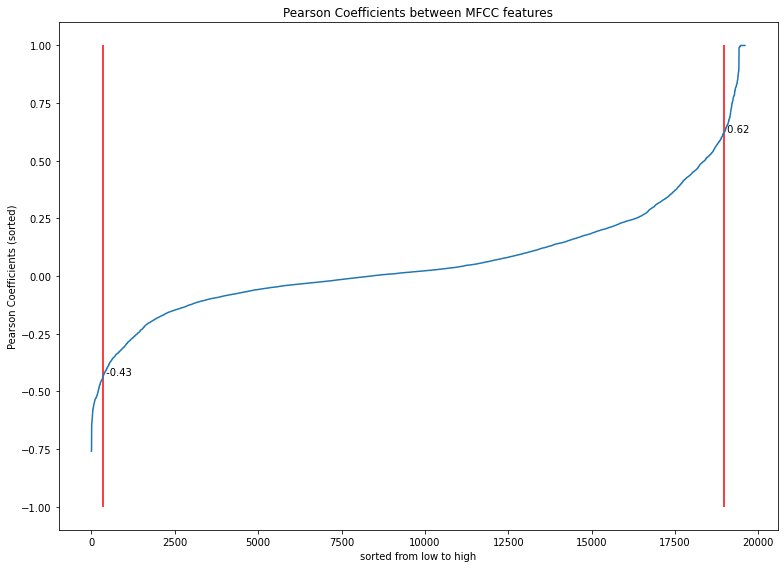

In [27]:
plt.figure(figsize=(11, 8))
plt.plot(corrs)
plt.vlines(x=p025, ymin=-1, ymax=1, label='2.5%', color='red')
plt.vlines(x=p975, ymin=-1, ymax=1, label='97.5%', color='red')
#plt.scatter(x=p025, y=p95[0], marker='o',color='black')
#plt.scatter(x=p975, y=p95[1], marker='o',color='black')
plt.annotate(' {:.2f}'.format(p95[0]),(p025,p95[0]))
plt.annotate(' {:.2f}'.format(p95[1]),(p975,p95[1]))
plt.title('Pearson Coefficients between MFCC features')
plt.xlabel('sorted from low to high')
plt.ylabel('Pearson Coefficients (sorted)')
plt.tight_layout()
plt.show()

We see that 95% of the pairwise correlations are between -.43 and .62. With only a few instances of high collinearity we may drop the highly correlated columns if it can improve performance of the model.